A first order statistic is linear combination of the data, like a mean, or a mean of a sliding box of differences. The first order statistic should only depend on deltaT, changes in time. This should be true because a) we've already removed Kepler systematics and b) Kepler's survey was much shorter than timescales that are important for stars. (side note: recurrent neural nets have this properties: only time differences exist. Also cosmology isn't recurrent). 

There are combinatorics-ly more second and third order statistics.

The variance is a second order statistic because the difference has been squared. (fun fact: we never have enough data to compute the uncertainty of these statistics, except by bootstrapping). You can basically do whatever you want. The power spectrum is a second order statistic: you dot product the data with a sine (linear) and square it and cosine (linear) and square it then add the two components. The power spectrum is kinda like a variance as a function of scale.

We want a third order statistic because we care about excursions in one direction (up). We want recurrent symmetry, i.e. a statistic based on delta time. And we want it to be sensitive to flares and preferably zero for Gaussian noise. Hogg out. Chalk drop. Could also be nice to have scale dependence -- it should peak in the middle, and go to zero at small scales (b/c poisson noise) and at larger scales (b/c central limit theorem, all noise looks Gaussian if you want long enough).

In [1]:
%matplotlib inline

import sys
sys.path
sys.path.append('/Users/ellie/Research/appaloosa')
from appaloosa import detrend  

from astropy.io import fits
import numpy as np
from pandas import rolling_median
import matplotlib.pyplot as plt
#from astropy.stats import lombscargle, LombScargle
import scipy.signal as signal
import math
import pandas as pd

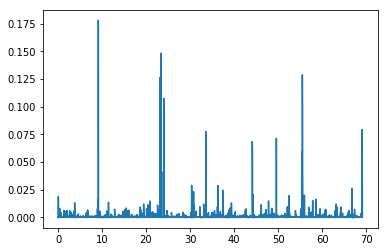

In [50]:
name = 'example' #'KIC9726699'
df = pd.read_csv('data/'+name+'.csv')
fin = np.isfinite(df['flux_det'])
time = df['time'][fin]
flux = df['flux'][fin]
flux_det = df['flux_det'][fin]
model = df['model'][fin]
ferr = df['ferr'][fin]

#plt.plot(time, flux)
plt.plot(time, flux - model)

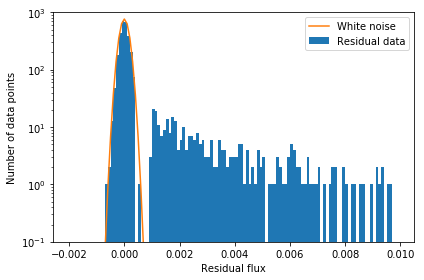

In [51]:
binwidth = 1e-4
bins = np.arange(-.002,0.01, binwidth)
plt.hist(flux_det, bins=bins, label='Residual data')

x = bins
xmean = 0.
sigma = np.nanmedian(ferr)

'''
# errors vary by a few parts per thousand... so this shouldn't make a difference (and doesn't)
y = 0
for sigma_i in ferr:
    y = y+binwidth/np.sqrt(2.*math.pi)/sigma_i*np.exp(-0.5*( (x-xmean)/sigma_i)**2.)
'''
sigma_i = sigma
y = len(flux_det)*binwidth/np.sqrt(2.*math.pi)/sigma_i*np.exp(-0.5*( (x-xmean)/sigma_i)**2.)

plt.plot(x,y, label='White noise')
plt.yscale('log')
plt.ylim(0.1,1e3)
plt.xlabel('Residual flux')
plt.ylabel('Number of data points')
plt.legend()
plt.tight_layout()

In [5]:
import scipy.stats as stats
print stats.skew(flux_det)
print stats.skew(y)

17.0420174836
3.6690700163


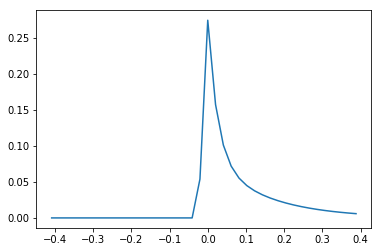

In [60]:
from scipy.signal import fftconvolve
from appaloosa import aflare

cadence = np.median(np.diff(time))
fwhm = 2.*cadence

flaretime = np.arange(-10*fwhm,10*fwhm,cadence) ## needs to be centered for convolution to be centered right
flaremodel = aflare.aflare1(flaretime, 0, fwhm, 1.)
flaremodel = flaremodel / np.sum(flaremodel) ## normalize (may or may not be right)
plt.plot(flaretime, flaremodel)

9.09861429167


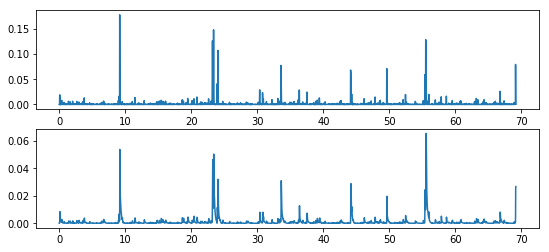

In [61]:
conv = fftconvolve(flux_det, flaremodel, mode='same')
print stats.skew(conv)

plt.figure(figsize=(9,4))
ax1 = plt.subplot(211)
plt.plot(time, flux_det)
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(time, conv)